In [1]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import imageio
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import time
from typing import Callable
from tqdm import tqdm
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import pickle
from os import path

In [2]:
print(gym.__file__)

/home/boiledcorn/minseok/relaxed_stochastic_control/.venv/lib/python3.12/site-packages/gymnasium/__init__.py


In [3]:
# ─── 환경 & 하이퍼파라미터 ────────────────────────────────────────────────
env       = gym.make('CartPole-v1', render_mode='rgb_array')
env       = RecordVideo(
            env,
            video_folder="videos/CartPole/",               # 저장 디렉터리 (없으면 생성됨)
            name_prefix="cartpole_eval"           # 파일명 접두사
)
tau       = env.unwrapped.tau
exponent  = 0.5
gamma     = math.exp(- exponent * tau)
sigma     = 0.1
lam = 0.1
device    = "cuda" if torch.cuda.is_available() else "cpu"
print('Device: ', device)
device    = torch.device(device)

Device:  cuda


/home/boiledcorn/minseok/relaxed_stochastic_control/.venv/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /home/boiledcorn/minseok/relaxed_stochastic_control/videos/CartPole folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [4]:
a = torch.tensor(1.0)
print(a.shape)
b = int(a)
print(b)

torch.Size([])
1


In [5]:
outer_iters = 30
eval_traj_num = 10

In [6]:
# ─── Value Network ───────────────────────────────────────────────────────
class ValueNet(nn.Module):
    def __init__(self, S, hidden=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(S, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        return self.net(x)


In [7]:
# CartPole dynamics 정의
def cartpole_dynamics(state: np.ndarray, action: int, env) -> np.ndarray:
    x, x_dot, theta, theta_dot = state
    force = env.force_mag if action == 1 else -env.force_mag
    g = env.gravity
    m = env.masspole
    M = env.masscart
    L = env.length
    dt = env.tau

    costheta = np.cos(theta)
    sintheta = np.sin(theta)
    total_mass = m + M
    polemass_length = m * L

    temp = (force + polemass_length * theta_dot**2 * sintheta) / total_mass
    thetaacc = (g * sintheta - costheta * temp) / (
        L * (4.0/3.0 - m * costheta**2 / total_mass)
    )
    xacc = temp - polemass_length * thetaacc * costheta / total_mass

    x       = x       + dt * x_dot
    x_dot   = x_dot   + dt * xacc
    theta   = theta   + dt * theta_dot
    theta_dot = theta_dot + dt * thetaacc

    return np.array([x, x_dot, theta, theta_dot])

def cartpole_dynamics_tensor(state: torch.Tensor, action: torch.Tensor, env) -> torch.Tensor:
    """
    state: Tensor of shape [B, 4]
    action: Tensor of shape [B] (0 or 1)
    returns: next_state of shape [B, 4]
    """
    x, x_dot, theta, theta_dot = state[:, 0], state[:, 1], state[:, 2], state[:, 3]
    env = env.unwrapped
    force = torch.where(action == 1, env.force_mag, -env.force_mag)

    g = env.gravity
    m = env.masspole
    M = env.masscart
    L = env.length
    dt = env.tau

    costheta = torch.cos(theta)
    sintheta = torch.sin(theta)
    total_mass = m + M
    polemass_length = m * L

    temp = (force + polemass_length * theta_dot**2 * sintheta) / total_mass
    thetaacc = (g * sintheta - costheta * temp) / (L * (4.0 / 3.0 - m * costheta**2 / total_mass))
    xacc = temp - polemass_length * thetaacc * costheta / total_mass

    x_new = x + dt * x_dot
    x_dot_new = x_dot + dt * xacc
    theta_new = theta + dt * theta_dot
    theta_dot_new = theta_dot + dt * thetaacc

    return torch.stack([x_new, x_dot_new, theta_new, theta_dot_new], dim=1)

In [8]:
# ─── 현재 정책(파라미터 없음) ─────────────────────────────────────────────
# 상태 s에서 가능한 두 액션(0,1)을 평가해 greedy 선택
def sample_action(value_net: nn.Module, s: np.ndarray, env) -> int:
    env = env.unwrapped
    
    # a) state → torch tensor (gradient on state)
    state = torch.tensor(s, dtype=torch.float32, device=device, requires_grad=True)
    # b) value와 state-gradient 계산
    v_s = value_net(state)                           # shape [1]
    grad_v = torch.autograd.grad(v_s, state)[0]      # shape [4]

    # c) 두 action 에 대한 f(s,a) 와 r(s,a) 계산
    f0 = (cartpole_dynamics(s, 0, env.unwrapped) - s) / tau   # numpy[4]
    f1 = (cartpole_dynamics(s, 1, env.unwrapped) - s) / tau

    f0_t = torch.from_numpy(f0).float().to(device)
    f1_t = torch.from_numpy(f1).float().to(device)

    # CartPole 의 즉시 보상은 각 스텝마다 1.0
    next_state0, next_state1 = s + f0, s + f1  # [B, 4]
    x0, x1 = next_state0[0], next_state1[0]
    theta0, theta1 = next_state0[2], next_state1[2]
    
    terminated0 = (
        (x0 < -env.x_threshold) | (x0 > env.x_threshold) |
        (theta0 < -env.theta_threshold_radians) | (theta0 > env.theta_threshold_radians)
    )
    terminated1 = (
        (x1 < -env.x_threshold) | (x1 > env.x_threshold) |
        (theta1 < -env.theta_threshold_radians) | (theta1 > env.theta_threshold_radians)
    )
    
    reward0, reward1 = float(~terminated0), float(~terminated1)

    # d) 스코어 계산: r + f·∇v
    score0 = reward0 + torch.dot(f0_t, grad_v)
    score1 = reward1 + torch.dot(f1_t, grad_v)

    scores = torch.stack([score0, score1], dim=0)
    return torch.softmax(scores / lam, dim = 0) # [2]

    

    # e) argmax
    #return 1 if score1.item() > score0.item() else 0

def sample_action_tensor(value_net: nn.Module, states: torch.Tensor, env) -> torch.Tensor:
    """
    states: Tensor of shape [B, 4]
    returns: Tensor of shape [B] with greedy actions (0 or 1)
    """
    env = env.unwrapped
    states = states.clone().detach().requires_grad_(True)  # [B, 4]

    v_s = value_net(states)  # [B, 1]
    grad_v = torch.autograd.grad(v_s.sum(), states, create_graph=True)[0]  # [B, 4]

    f0 = (cartpole_dynamics_tensor(states, torch.zeros(states.shape[0], dtype=torch.long, device=states.device), env) - states) / tau
    f1 = (cartpole_dynamics_tensor(states, torch.ones(states.shape[0], dtype=torch.long, device=states.device), env) - states) / tau

    next_states0, next_states1 = states + f0, states + f1  # [B, 4]
    x0, x1 = next_states0[:, 0], next_states1[:, 0]
    theta0, theta1 = next_states0[:, 2], next_states1[:, 2]
    
    terminated0 = (
        (x0 < -env.x_threshold) | (x0 > env.x_threshold) |
        (theta0 < -env.theta_threshold_radians) | (theta0 > env.theta_threshold_radians)
    )
    terminated1 = (
        (x1 < -env.x_threshold) | (x1 > env.x_threshold) |
        (theta1 < -env.theta_threshold_radians) | (theta1 > env.theta_threshold_radians)
    )
    
    reward0, reward1 = (~terminated0).float(), (~terminated1).float()
    # reward: shape [B]
    
    score0 = reward0 + torch.sum(f0 * grad_v, dim=1)  # [B]
    score1 = reward1 + torch.sum(f1 * grad_v, dim=1)  # [B]

    scores = torch.stack([score0, score1], dim=1)
    return torch.softmax(scores / lam, dim = 1) # [B, 2]


In [9]:

def train_value_parallel(
    env,
    value_net: nn.Module,
    opt_v: torch.optim.Optimizer,
    greedy_action_tensor: Callable,
    cartpole_dynamics_tensor: Callable,
    epochs: int = 1000,
    batch_size: int = 64,
    device: str = 'cpu',
    exponent: float = 1.0,
):
    env = env.unwrapped
    mse_loss = nn.MSELoss()

    value_net_copy = type(value_net)(env.observation_space.shape[0]).to(device)
    value_net_copy.load_state_dict(value_net.state_dict())

    start = time.time()

    for epoch in range(1, epochs + 1):
        # 1) 상태 샘플링
        s_np = np.empty((batch_size, 4), dtype=np.float32)
        s_np[:, 0] = np.random.uniform(-4.8, 4.8, size=batch_size)
        s_np[:, 1] = np.random.uniform(-5.0, 5.0, size=batch_size)
        s_np[:, 2] = np.random.uniform(-0.418, 0.418, size=batch_size)
        s_np[:, 3] = np.random.uniform(-5.0, 5.0, size=batch_size)

        states = torch.tensor(s_np, dtype=torch.float32, device=device, requires_grad=True)  # [B, 4]
        opt_v.zero_grad()

        # 2) v(s), ∇v(s)
        v_s = value_net(states)  # [B, 1]
        grad_v = torch.autograd.grad(v_s.sum(), states, create_graph=True)[0]  # [B, 4]
        laplacian = torch.zeros(states.shape[0], device=device)
        for i in range(states.shape[1]):
            # grad_v[:, i] 에 대한 states[:, i] 방향 2차 도함수
            second_deriv = torch.autograd.grad(grad_v[:, i].sum(), states, create_graph=True)[0][:, i]
            laplacian = laplacian + second_deriv
        # trace term: (1/2) * σ^2 * laplacian
        trace_term = 0.5 * sigma**2 * laplacian.unsqueeze(1)  # [B, 1]

        # 3) sample action (벡터화)
        actions_dist = sample_action_tensor(value_net_copy, states.detach(), env)  # [B, 2]
        log_actions = torch.log(actions_dist)
        entropies = -torch.sum(actions_dist * log_actions, dim=1)
        #bernoulli = torch.distributions.Bernoulli(actions_dist[:,1])
        #actions = bernoulli.sample() # [B]

        a0 = torch.zeros(batch_size, device=device)
        a1 = torch.ones(batch_size, device=device)

        # 4) dynamics
        next_states0 = cartpole_dynamics_tensor(states.detach(), a0, env)  # [B, 4]
        next_states1 = cartpole_dynamics_tensor(states.detach(), a1, env)  # [B, 4]
        b0 = next_states0 - states.detach()  # [B, 4]
        b1 = next_states1 - states.detach()  # [B, 4]

        # 5) PDE 잔차
        x = states[:, 0]
        theta = states[:, 2]
        terminated = (
            (x < -env.x_threshold) | (x > env.x_threshold) |
            (theta < -env.theta_threshold_radians) | (theta > env.theta_threshold_radians)
        )
        reward = (~terminated).float()
        
        dot_product0 = torch.sum(b0 * grad_v, dim=1, keepdim=True)  # [B, 1]
        dot_product1 = torch.sum(b1 * grad_v, dim=1, keepdim=True)  # [B, 1]
        residuals0 = exponent * v_s - (trace_term + dot_product0 + reward.unsqueeze(1))  # [B, 1]
        residuals1 = exponent * v_s - (trace_term + dot_product1 + reward.unsqueeze(1))  # [B, 1]

        residuals = residuals0.squeeze(1) * actions_dist[:, 0] + residuals1.squeeze(1) * actions_dist[:, 1]
        residuals -= lam * entropies
        # 6) 손실 계산 및 업데이트
        loss = mse_loss(residuals, torch.zeros_like(residuals))
        loss.backward()
        opt_v.step()

        if epoch % 100 == 0:
            elapsed = time.time() - start
            print(f"[Epoch {epoch}/{epochs}] PDE MSE Loss: {loss.item():.4e}  Runtime: {elapsed:.2f}sec")

In [10]:
value_net = ValueNet(env.observation_space.shape[0]).to(device)
opt_v     = optim.Adam(value_net.parameters(), lr=1e-3)

In [11]:
# ─── Main Loop: Approximate Policy Iteration ───────────────────────────────
start = time.time()
total_reward = []
total_step = []
for it in range(outer_iters):
    # 가치함수 업데이트
    print(f'[Iter {it+1}/{outer_iters}] Starts')
    train_value_parallel(env, value_net, opt_v, sample_action_tensor, cartpole_dynamics_tensor, 3000, 10000, device, exponent)
    elapsed = time.time() - start
    print(f"[Iter {it+1}/{outer_iters}] Done. Runtime: {elapsed:.2f}sec")
    print("Evaluation start")

    eval_reward = 0
    eval_step = 0
    for ep in range(eval_traj_num):
        # env.reset() 가 (obs, info) 튜플일 수 있으므로 unpack
        init = env.reset()
        s = init[0] if isinstance(init, tuple) else init
    
        total = 0
        done = False
        step = 0
        
        #all_frames = []
        while not done:
            #frame = env.render()
            #all_frames.append(frame)
            step += 1
            a_dist = sample_action(value_net, s, env)
            bernoulli = torch.distributions.Bernoulli(a_dist[1])
            a = int(bernoulli.sample())
            s2, r, terminated, truncated, _ = env.step(a)
            
            # ─── Gaussian noise 주입 ────────────────────────────
            tau = env.unwrapped.tau
            # 평균 0, 분산 = sigma^2 * tau 인 정규분포
            noise = np.random.normal(
                loc=0.0,
                scale=sigma * np.sqrt(tau),
                size=s2.shape
            )
            s = s2 + noise
            # 실제 env.state 를 덮어쓰기
            env.unwrapped.state = s
            
            done = terminated or truncated
    
            total += r * (gamma ** step)

        eval_reward += total
        eval_step += step
    eval_reward /= eval_traj_num
    eval_step /= eval_traj_num
    print(f'Estimated Value: {eval_reward} Estimated Step: {eval_step} Runtime: {time.time() - start}')
    total_reward.append(eval_reward)
    total_step.append(eval_step)
        

    

    

[Iter 1/30] Starts
[Epoch 100/3000] PDE MSE Loss: 1.3864e-01  Runtime: 3.60sec
[Epoch 200/3000] PDE MSE Loss: 1.3670e-01  Runtime: 6.63sec
[Epoch 300/3000] PDE MSE Loss: 1.3730e-01  Runtime: 9.76sec
[Epoch 400/3000] PDE MSE Loss: 1.0604e-01  Runtime: 12.83sec
[Epoch 500/3000] PDE MSE Loss: 5.5608e-02  Runtime: 15.90sec
[Epoch 600/3000] PDE MSE Loss: 5.3576e-02  Runtime: 18.88sec
[Epoch 700/3000] PDE MSE Loss: 5.1582e-02  Runtime: 21.80sec
[Epoch 800/3000] PDE MSE Loss: 4.9049e-02  Runtime: 24.79sec
[Epoch 900/3000] PDE MSE Loss: 4.9641e-02  Runtime: 28.19sec
[Epoch 1000/3000] PDE MSE Loss: 4.8525e-02  Runtime: 31.61sec
[Epoch 1100/3000] PDE MSE Loss: 4.7774e-02  Runtime: 35.25sec
[Epoch 1200/3000] PDE MSE Loss: 4.7210e-02  Runtime: 38.28sec
[Epoch 1300/3000] PDE MSE Loss: 4.2341e-02  Runtime: 41.53sec
[Epoch 1400/3000] PDE MSE Loss: 4.1643e-02  Runtime: 44.74sec
[Epoch 1500/3000] PDE MSE Loss: 4.0417e-02  Runtime: 47.73sec
[Epoch 1600/3000] PDE MSE Loss: 3.8496e-02  Runtime: 50.81sec
[

/home/boiledcorn/minseok/relaxed_stochastic_control/.venv/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Estimated Value: 87.20855935277902 Estimated Step: 214.8 Runtime: 105.74200701713562
[Iter 2/30] Starts
[Epoch 100/3000] PDE MSE Loss: 2.3100e-02  Runtime: 3.16sec
[Epoch 200/3000] PDE MSE Loss: 2.2197e-02  Runtime: 6.52sec
[Epoch 300/3000] PDE MSE Loss: 2.0837e-02  Runtime: 10.16sec
[Epoch 400/3000] PDE MSE Loss: 2.0431e-02  Runtime: 13.89sec
[Epoch 500/3000] PDE MSE Loss: 1.9377e-02  Runtime: 17.32sec
[Epoch 600/3000] PDE MSE Loss: 1.9140e-02  Runtime: 20.66sec
[Epoch 700/3000] PDE MSE Loss: 1.9402e-02  Runtime: 24.01sec
[Epoch 800/3000] PDE MSE Loss: 1.8681e-02  Runtime: 27.26sec
[Epoch 900/3000] PDE MSE Loss: 1.7433e-02  Runtime: 30.44sec
[Epoch 1000/3000] PDE MSE Loss: 1.7362e-02  Runtime: 33.73sec
[Epoch 1100/3000] PDE MSE Loss: 1.7914e-02  Runtime: 37.10sec
[Epoch 1200/3000] PDE MSE Loss: 1.6686e-02  Runtime: 40.10sec
[Epoch 1300/3000] PDE MSE Loss: 1.6073e-02  Runtime: 43.53sec
[Epoch 1400/3000] PDE MSE Loss: 1.5868e-02  Runtime: 46.79sec
[Epoch 1500/3000] PDE MSE Loss: 1.5300e

KeyboardInterrupt: 

In [12]:
print(f'Time per iteration: {799.115/30}')

Time per iteration: 26.637166666666666


In [14]:
import os
os.makedirs("results/test/CartPole", exist_ok=True)

In [15]:
with open('results/test/CartPole/Value.pkl', 'wb') as f:
    pickle.dump(total_reward, f)

In [16]:
with open('results/test/CartPole/Value.pkl', 'rb') as f:
    total_reward = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'results/CartPole/reward_plot.png'

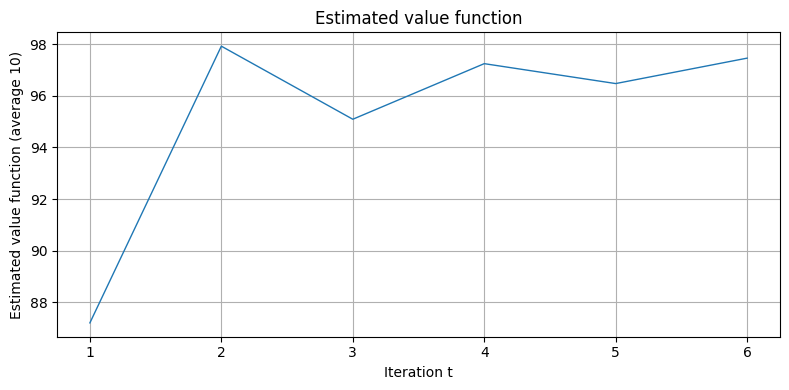

In [19]:


its = np.arange(1, 7)

plt.figure(figsize=(8, 4))
plt.plot(its, total_reward, linewidth=1.0, label=r'Value', color='tab:blue')


plt.xlabel('Iteration t')
plt.ylabel('Estimated value function (average 10)')
# plt.yscale('log')  # 필요시 로그 스케일
plt.title('Estimated value function')
plt.grid(True)
#plt.legend()
plt.tight_layout()
results_dir = 'results/CartPole/'
plot_file = path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")
plt.show()



In [34]:
with open('results/CartPole/Step.pkl', 'wb') as f:
    pickle.dump(total_step, f)

In [35]:
with open('results/CartPole/Step.pkl', 'rb') as f:
    total_step = pickle.load(f)

Average step plot saved to results/CartPole/average_step.png


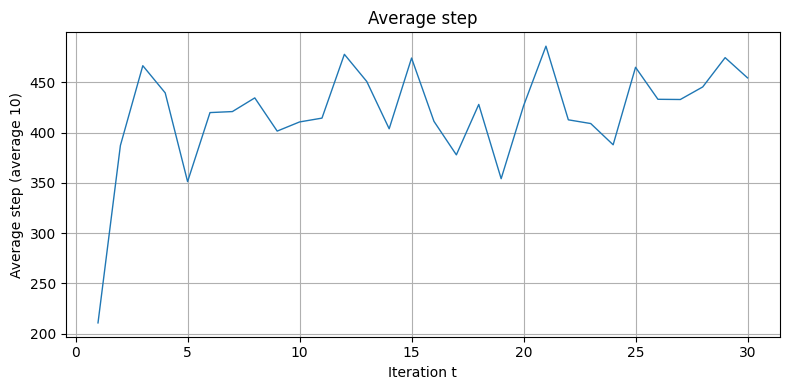

In [31]:

plt.figure(figsize=(8, 4))
plt.plot(its, total_step, linewidth=1.0, label=r'Value', color='tab:blue')


plt.xlabel('Iteration t')
plt.ylabel('Average step (average 10)')
# plt.yscale('log')  # 필요시 로그 스케일
plt.title('Average step')
plt.grid(True)
#plt.legend()
plt.tight_layout()
plot_file = path.join(results_dir, "average_step.png")
plt.savefig(plot_file)
print(f"Average step plot saved to {plot_file}")
plt.show()



In [36]:
torch.save(value_net.state_dict(), 'results/CartPole/model.pth')

In [37]:
value_net = ValueNet(env.observation_space.shape[0]).to(device)
value_net.load_state_dict(torch.load('results/CartPole/model.pth', map_location=device))

<All keys matched successfully>

In [38]:
# ─── 학습된 정책 평가 ────────────────────────────────────────────────────

for ep in range(10):
    # env.reset() 가 (obs, info) 튜플일 수 있으므로 unpack
    init = env.reset()
    s = init[0] if isinstance(init, tuple) else init

    total = 0
    done = False
    step = 0
    
    all_frames = []
    while not done:
        frame = env.render()
        all_frames.append(frame)
        step += 1
        a_dist = sample_action(value_net, s, env)
        bernoulli = torch.distributions.Bernoulli(a_dist[1])
        a = int(bernoulli.sample())
        s2, r, terminated, truncated, _ = env.step(a)
        
        # ─── Gaussian noise 주입 ────────────────────────────
        tau = env.unwrapped.tau
        # 평균 0, 분산 = sigma^2 * tau 인 정규분포
        noise = np.random.normal(
            loc=0.0,
            scale=sigma * np.sqrt(tau),
            size=s2.shape
        )
        s = s2 + noise
        # 실제 env.state 를 덮어쓰기
        env.unwrapped.state = s
        
        done = terminated or truncated

        total += r * (gamma ** step)
        

        #env.render()

    print(f"Eval Episode {ep+1} → Step: {step}, Reward: {total}")
    path = f"{env.video_folder}{env.name_prefix}_{ep+1}.gif"
    imageio.mimsave(path, all_frames, fps=30)

env.close()


Eval Episode 1 → Step: 261, Reward: 92.18408494883629
Eval Episode 2 → Step: 500, Reward: 98.83040199058942
Eval Episode 3 → Step: 500, Reward: 98.83040199058942
Eval Episode 4 → Step: 500, Reward: 98.83040199058942
Eval Episode 5 → Step: 375, Reward: 97.16079802118313
Eval Episode 6 → Step: 461, Reward: 98.51061911714586
Eval Episode 7 → Step: 500, Reward: 98.83040199058942
Eval Episode 8 → Step: 312, Reward: 95.10715827660636
Eval Episode 9 → Step: 500, Reward: 98.83040199058942
Eval Episode 10 → Step: 392, Reward: 97.52662787066198


In [39]:
# ─── 학습된 정책 평가 ────────────────────────────────────────────────────
# noise 없는 환경

for ep in range(10):
    # env.reset() 가 (obs, info) 튜플일 수 있으므로 unpack
    init = env.reset()
    s = init[0] if isinstance(init, tuple) else init

    total = 0
    done = False
    step = 0
    
    all_frames = []
    while not done:
        frame = env.render()
        all_frames.append(frame)
        step += 1
        a_dist = sample_action(value_net, s, env)
        bernoulli = torch.distributions.Bernoulli(a_dist[1])
        a = int(bernoulli.sample())
        s2, r, terminated, truncated, _ = env.step(a)
        
        # ─── Gaussian noise 주입 ────────────────────────────
        tau = env.unwrapped.tau
        # 평균 0, 분산 = sigma^2 * tau 인 정규분포
        #noise = np.random.normal(
            #loc=0.0,
            #scale=sigma * np.sqrt(tau),
            #size=s2.shape
        #)
        s = s2
        # 실제 env.state 를 덮어쓰기
        env.unwrapped.state = s
        
        done = terminated or truncated

        total += r * (gamma ** step)
        

        #env.render()

    print(f"Eval Episode {ep+1} → Step: {step}, Reward: {total}")
    path = f"{env.video_folder}{env.name_prefix}_{ep+1}.gif"
    imageio.mimsave(path, all_frames, fps=30)

env.close()

Eval Episode 1 → Step: 421, Reward: 98.02360731035225
Eval Episode 2 → Step: 500, Reward: 98.83040199058942
Eval Episode 3 → Step: 500, Reward: 98.83040199058942
Eval Episode 4 → Step: 496, Reward: 98.80304116850586
Eval Episode 5 → Step: 500, Reward: 98.83040199058942
Eval Episode 6 → Step: 500, Reward: 98.83040199058942
Eval Episode 7 → Step: 500, Reward: 98.83040199058942
Eval Episode 8 → Step: 500, Reward: 98.83040199058942
Eval Episode 9 → Step: 500, Reward: 98.83040199058942
Eval Episode 10 → Step: 500, Reward: 98.83040199058942
